<a href="https://colab.research.google.com/github/andrerabelom/Data-Analyst-Portfolio/blob/main/Desafio_4_DNC_Andr%C3%A9_Rabelo_Moraes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio 4 DNC - André Rabelo Moraes - RID 106609

First, we have to import all necessary packages and libraries to solve the problem.

In [53]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

Second, we need to read the .csv file and load it into a pandas dataFrame. The "df" variable was created to store it.

In [54]:
df = pd.read_csv('/content/MKT.csv') 

#First Step: Descriptive Data Analysis:

At the first moment, it's important to check technical details about the data in order to check if any values are missing, the types of each column, etc.

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   youtube    171 non-null    float64
 1   facebook   171 non-null    float64
 2   newspaper  171 non-null    float64
 3   sales      171 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


Ok, now we know that all entries are valid, and we have 171 lines of code, and 4 columns (the first one is the index column).
Next step is to perform a EDA on the data.

We know that each column from [youtube, facebook, newspaper] represent the value spent on advertising on that specific platform.
The sales column represents the amount of sales made on that particular date frame.

Two problems found: 

1) We don't know the date frame.. let's assume it's monthly;

2) We don't know the units of the cost (if it's thousands of dollar, millions, etc).


#Second Step: Exploratory Data Analysis (EDA):

In [56]:
df.describe()

,youtube,facebook,newspaper,sales
count,171.000000,171.000000,171.000000,171.000000
mean,178.021053,27.671579,35.240000,16.922807
std,102.449597,17.913532,24.902918,6.314608
min,0.840000,0.000000,0.360000,1.920000
25%,91.080000,11.700000,13.740000,12.540000
50%,179.760000,26.760000,31.080000,15.480000
75%,262.980000,43.680000,50.880000,20.820000
max,355.680000,59.520000,121.080000,32.400000


From the describe() function on the dataframe, we can already see a few things:

1) The majority of the money was spent on youtube advertising. However, it was not constant (the standard variation is quite high)

2) Facebook and newspaper share similar information.. The only one that is very diffent is the max.

3) In the sales column, we had at least one month with very low sales.. We should check how was the advertising spent on that month to check for some insights.


Let's begin to check for some abnormalities in our data set, like outliers. Also, let's see how the data is spread.

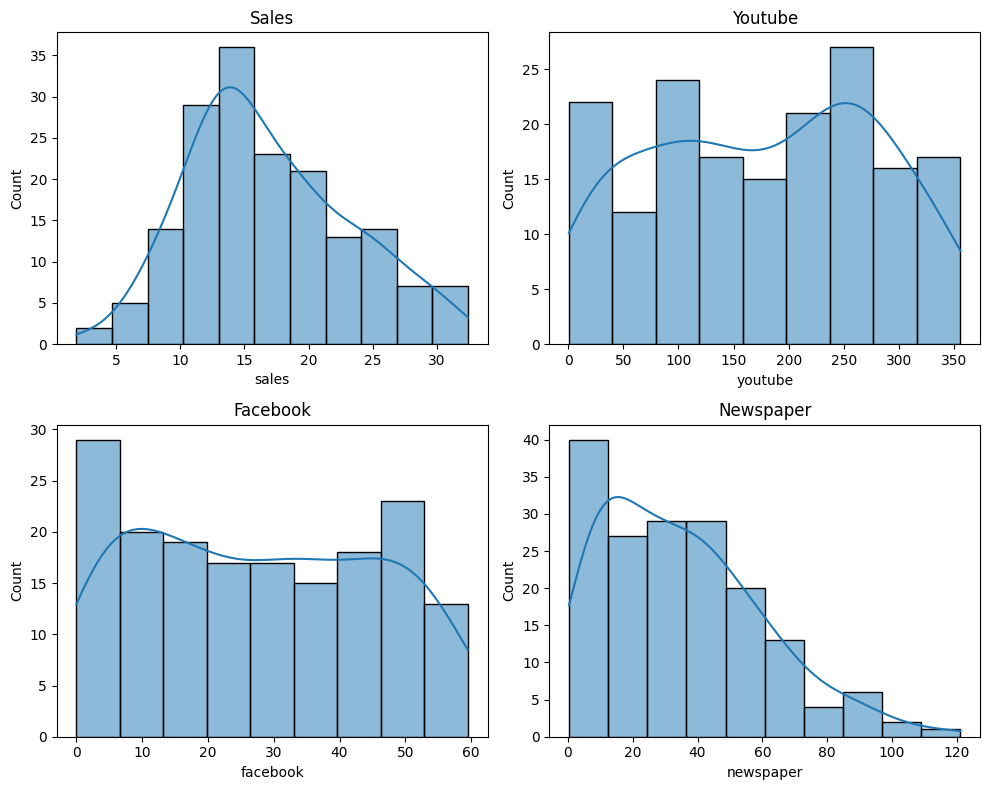

In [57]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot Sales histogram
sns.histplot(ax=axes[0, 0], data=df, x='sales', kde=True)
axes[0, 0].set_title('Sales')

# Plot Youtube histogram
sns.histplot(ax=axes[0, 1], data=df, x='youtube', kde=True)
axes[0, 1].set_title('Youtube')

# Plot Facebook histogram
sns.histplot(ax=axes[1, 0], data=df, x='facebook', kde=True)
axes[1, 0].set_title('Facebook')

# Plot Newspaper histogram
sns.histplot(ax=axes[1, 1], data=df, x='newspaper', kde=True)
axes[1, 1].set_title('Newspaper')

# Adjust spacing
plt.tight_layout()

# Show the plots
plt.show()

As we can see, the sales have a somewhat normal distribuition. As per the independent variables, like seen on the describe() function, we can see that Youtube and Facebook investments are more evenly distributed than newspaper.

We can also plot it a little bit differently, with a boxplot. That way, we can check for possible ouliers.


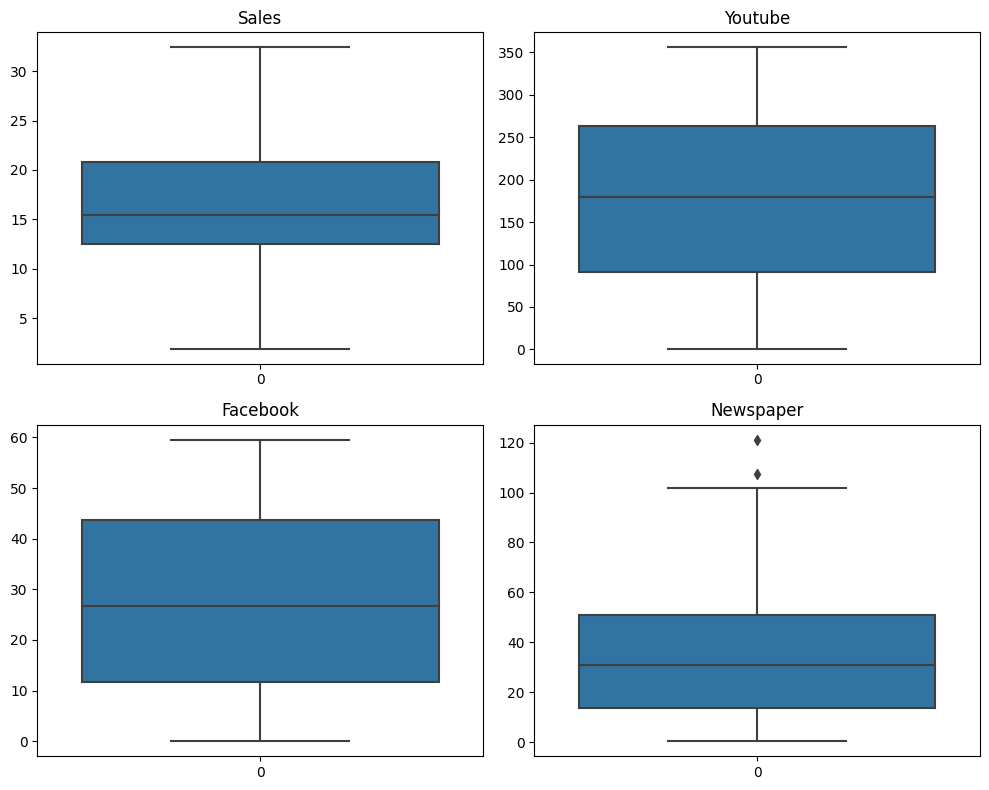

In [58]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot Sales boxplot
sns.boxplot(ax=axes[0, 0], data=df['sales'])
axes[0, 0].set_title('Sales')

# Plot Youtube boxplot
sns.boxplot(ax=axes[0, 1], data=df['youtube'])
axes[0, 1].set_title('Youtube')

# Plot Facebook boxplot
sns.boxplot(ax=axes[1, 0], data=df['facebook'])
axes[1, 0].set_title('Facebook')

# Plot Newspaper boxplot
sns.boxplot(ax=axes[1, 1], data=df['newspaper'])
axes[1, 1].set_title('Newspaper')

# Adjust spacing
plt.tight_layout()

# Show the plots
plt.show()




Technically speaking, by means of the "standard" quantiles, we only have possible outliers on the "newspaper" column. Let's count how many there are, to see if it's needed to remove them.

In [59]:
# Define outlier criteria (e.g., values below lower whisker or above upper whisker)
lower_whisker = df['newspaper'].quantile(0.25) - 1.5 * (df['newspaper'].quantile(0.75) - df['newspaper'].quantile(0.25))
upper_whisker = df['newspaper'].quantile(0.75) + 1.5 * (df['newspaper'].quantile(0.75) - df['newspaper'].quantile(0.25))

# Count of ouliers on the newspaper column
df[(df['newspaper'] <= lower_whisker) | (df['newspaper'] >= upper_whisker)].count()

youtube      2
facebook     2
newspaper    2
sales        2
dtype: int64

Due to it's low correlation and representing only roughly 1% of the column, I'm deciding not to remove these values (or replace them by a median on average of the column)

Next, let's check some correlation between variables.

<Axes: >

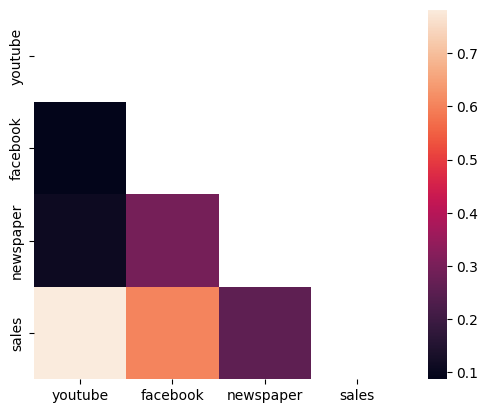

In [60]:
# Calculate correlation between each pair of variable
corr_matrix=df.corr()
 
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, square=True)



Analyzing the heatmap above, it's possible to see that youtube tends to bring greater returns, followed by facebook, and then comes newspaper. That makes sense, since youtube is always full of people on internet, facebook is kind of declining, and newspaper is probably used only by the older people.

It's important now to check the evolution of sales, and compare it to the investments made on each platform.
As we have only numerical features, we're going to use a scatterplot to visualize them altogether.

<Axes: xlabel='newspaper', ylabel='sales'>

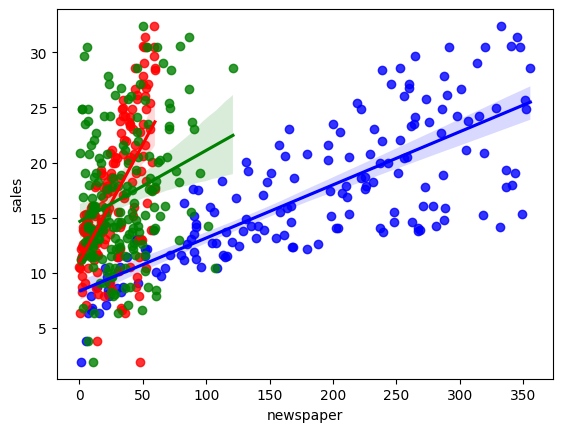

In [61]:
# use the function regplot to make a scatterplot

sns.regplot(x=df["youtube"], y=df["sales"], color='blue')
sns.regplot(x=df["facebook"], y=df["sales"], color='red')
sns.regplot(x=df["newspaper"], y=df["sales"], color='green')

 The above graph shows that facebook and newspaper have a steeper angle on the fit line, which COULD indicate that it has a strong correlation.. But as we have seen before, they are not the highest. So, this graph can be misleading us into something that is not true. We should check them separately too.
 We will plot them in a few blocks of code.

 A possibly interesting analysis is plotting the sum of the 3 investments against sales, so that we can comprehend if there is a linear relationship or not.

<Axes: xlabel='Total', ylabel='sales'>

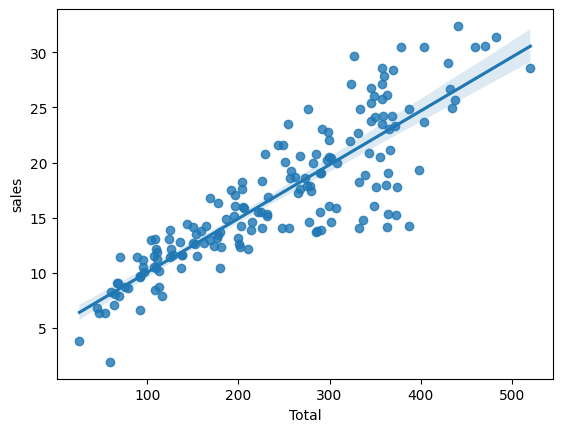

In [62]:
df['Total'] = df['youtube'] + df['facebook']+df['newspaper']

sns.regplot(x=df["Total"], y=df["sales"])


It's possible to notice that we still have an overall linear tendency as we invest more to have more sales (which makes total sense).
Below, we will plot the 3 independent variables against the 1 dependent variable, to check for tendencies altogether.

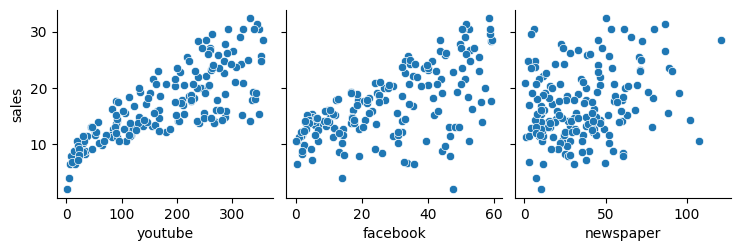

In [63]:
sns.pairplot(df, x_vars=['youtube','facebook','newspaper'], y_vars='sales')


With the graphs above, we can note a high linearity of sales with Youtube and Facebook investments. However, for Newspapers, the relationship is not so clear.


# Third Step: Modeling
Now we will begin to prepare our dataset for modeling and training.

There will be 2 comparisons: 

1) The first one using all the independent variables for the training of the model;

2) The second one, removing "Newspaper" from the variables.

We will also be using different regressors, to check which of them respond better for this dataset and type of data.
We will be using:

*   Simple Linear Regression
*   Ridge Linear Regression
*   SGB Regression
*   Random Forest Regression






In [64]:
X = df[['youtube','facebook','newspaper']]
Y = df[['sales']]


#X2 is for the Second Analysis (without 'newspaper' column)
X2 = df[['youtube','facebook']]


#It's important to always normalize the variables. Since all columns represent investment, all should be in the same base.
#That being said, we divide the values by 355.68, which if the max() of investment values.
X_scaled = X.copy()
X_scaled = X_scaled/355.68

X2_scaled = X2.copy()
X2_scaled = X2_scaled/355.68



#To make sure the model will not be overfitted to the training dataset and return and "fake" value of R², it's interesting to separate the data into train and test data sets.
#In this case, I'm utilizing 70% of the data set for training, and 30% for testing.
X_train, X_valid, Y_train, Y_valid = train_test_split(X_scaled, Y, train_size=0.7, test_size=0.3,
                                                                random_state=42)


X2_train, X2_valid, Y2_train, Y2_valid = train_test_split(X2_scaled, Y, train_size=0.7, test_size=0.3,
                                                                random_state=42)


##Number 1 Analysis:

Simples linear Regression score:  0.882423505618885
Ridge Linear Regression score:  0.7112001108361434
SGD score:  0.8786667168544104
Random Forest Regression score:  0.9745227914667136


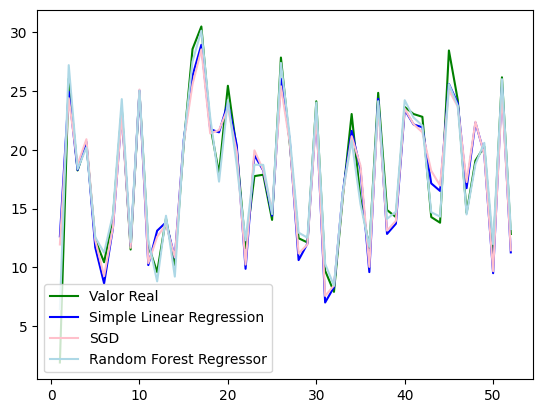

In [65]:
#Simple Linear Regression

lrm = LinearRegression()
lrm.fit(X_train,Y_train)
Y_pred_lrm = lrm.predict(X_valid)
r_lrm = r2_score(Y_valid, Y_pred_lrm)
print(f'Simples linear Regression score:  {r_lrm}')


#Ridge Linear Regression
ridge_lr = Ridge(alpha=1.0)
ridge_lr.fit(X_train, Y_train)
Y_pred_ridge = ridge_lr.predict(X_valid)
r_ridge = r2_score(Y_valid, Y_pred_ridge)
print(f'Ridge Linear Regression score:  {r_ridge}')


#SGD Regressor
SGD_r = SGDRegressor(max_iter=100000, tol=1e-5, eta0=0.01)
SGD_r.fit(X_train, np.ravel(Y_train))
Y_pred_SGD = SGD_r.predict(X_valid)
r_SGD = r2_score(Y_valid, Y_pred_SGD)
print(f'SGD score:  {r_SGD}')

#Random Forest Regressor
rfr_model = RandomForestRegressor(n_estimators=1000, random_state=42, criterion='squared_error')
rfr_model.fit(X_train, np.ravel(Y_train))
Y_pred_rfr = rfr_model.predict(X_valid)
r_rfr = r2_score(Y_valid, Y_pred_rfr)
print(f'Random Forest Regression score:  {r_rfr}')



c = [i for i in range(1,53,1)]


plt.plot(c,Y_valid, color='green', label='Valor Real')
plt.plot(c,Y_pred_lrm, color='blue', label='Simple Linear Regression')
#plt.plot(c,Y_pred_ridge, color='red')
plt.plot(c,Y_pred_SGD, color='pink', label='SGD')
plt.plot(c,Y_pred_rfr, color='lightblue',label='Random Forest Regressor')
plt.legend()
plt.show()

##Number 2 Analysis:

Simple linear Regression Score:  0.8824796927714542
Ridge Linear Regression Score:  0.6971821578070967
SGD score:  0.8756763535302063
Random Forest Regression score:  0.9787551836707175


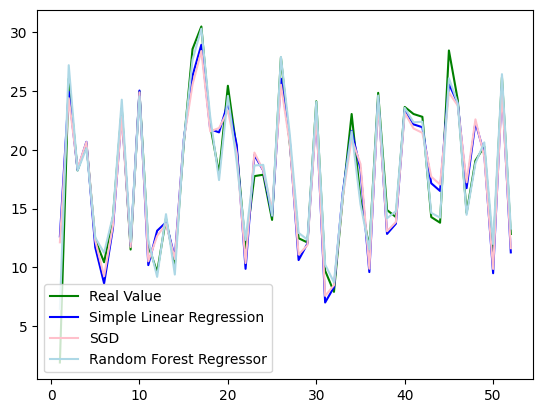

In [66]:
#Simple Linear Regression

lrm_2 = LinearRegression()
lrm_2.fit(X2_train,Y2_train)
Y2_pred_lrm = lrm_2.predict(X2_valid)
r_lrm_2 = r2_score(Y2_valid, Y2_pred_lrm)
print(f'Simple linear Regression Score:  {r_lrm_2}')


#Ridge Linear Regression
ridge_lr_2 = Ridge(alpha=1.0)
ridge_lr_2.fit(X2_train, Y2_train)
Y2_pred_ridge = ridge_lr_2.predict(X2_valid)
r_ridge_2 = r2_score(Y2_valid, Y2_pred_ridge)
print(f'Ridge Linear Regression Score:  {r_ridge_2}')


#SGD Regressor
SGD_r_2 = SGDRegressor(max_iter=100000, tol=1e-5, eta0=0.01)
SGD_r_2.fit(X2_train, np.ravel(Y2_train))
Y2_pred_SGD = SGD_r_2.predict(X2_valid)
r_SGD_2 = r2_score(Y2_valid, Y2_pred_SGD)
print(f'SGD score:  {r_SGD_2}')


#Random Forest Regressor
rfr_model_2 = RandomForestRegressor(n_estimators=1000, random_state=42, criterion='squared_error')
rfr_model_2.fit(X2_train, np.ravel(Y2_train))
Y2_pred_rfr = rfr_model_2.predict(X2_valid)
r_rfr_2 = r2_score(Y2_valid, Y2_pred_rfr)
print(f'Random Forest Regression score:  {r_rfr_2}')





d = [i for i in range(1,53,1)]

plt.plot(d,Y2_valid, color='green', label='Real Value')
plt.plot(d,Y2_pred_lrm, color='blue', label='Simple Linear Regression')
#plt.plot(d,Y_pred_ridge, color='red')
plt.plot(d,Y2_pred_SGD, color='pink', label='SGD')
plt.plot(c,Y2_pred_rfr, color='lightblue',label='Random Forest Regressor')

plt.legend()
plt.show()

We can see that, for the parameters used, The Simple Linear Regression performed better than the SGB Regressor (only slightly) and the Ridge Regressor (a lot better).
That was true for both analysis (With and without the "newspaper" column).

However, on both analysis the Random Forest Regressor got way better results. On the second analysis (the one where we don't use the newspaper column) got a .4% better result than the first one.. So we are going to use this one as the final one.
There could be more adaptation that could be done to increase the R² value.. but I will leave it at 97.8% for now.

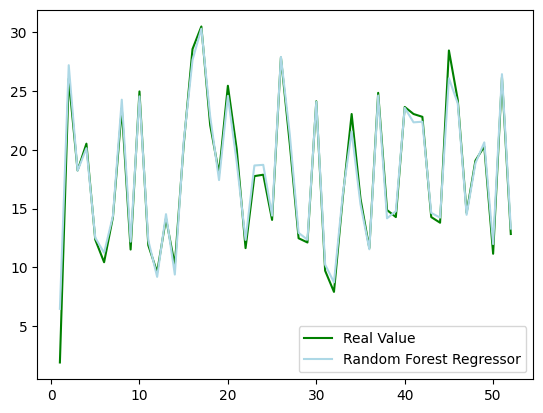

In [67]:
plt.plot(d,Y2_valid, color='green', label='Real Value')
plt.plot(c,Y2_pred_rfr, color='lightblue',label='Random Forest Regressor')

plt.legend()
plt.show()

There is a way to understand more clearly how the regression model was trained and how it turned out, and it's parameters for decisions.

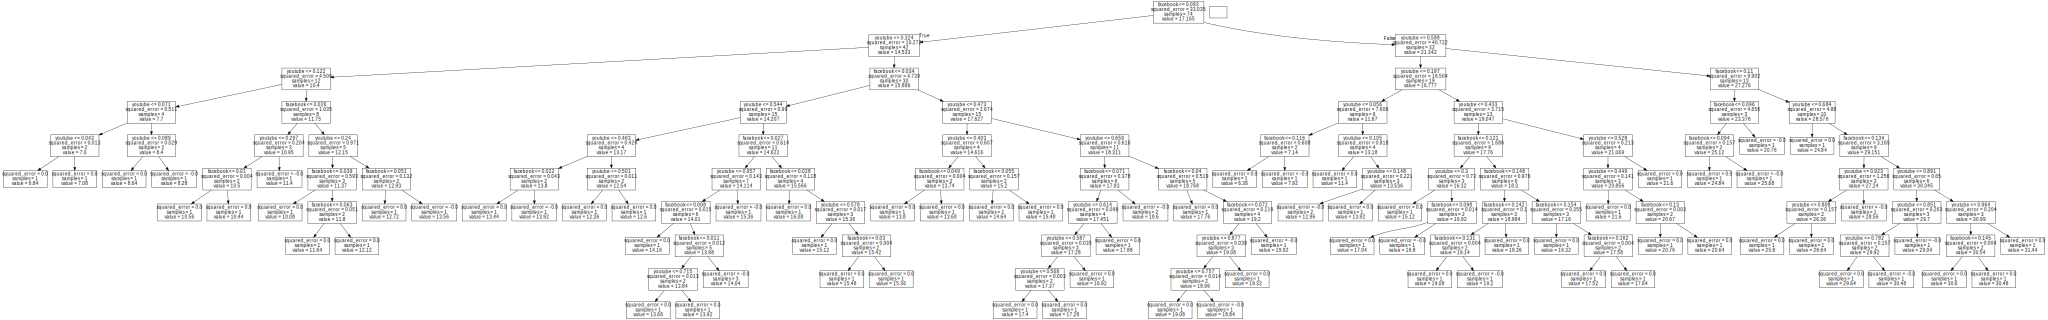

In [68]:
import graphviz
from sklearn import tree
import pydotplus

# Assuming you have a trained random forest model named 'rf_model'
# Extract a decision tree from the random forest
i=0

decision_tree = rfr_model_2.estimators_[i]  # Replace 'i' with the desired index

# Export the decision tree in DOT format
dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=X2_train.columns.values)

# Create a graph from the DOT data
graph = pydotplus.graph_from_dot_data(dot_data)

# Display the decision tree plot
graphviz.Source(graph.to_string())


#If we want to save it a to a PNG file, we can use the code below.
# Save the decision tree plot as a PNG file
#graph.write_png('decision_tree.png')

#Fourth Step: Shipping to Production for Predictions

##Now comes the most important part, which is preparing for production deployment. The best regressor was the Random Forest Regressor, using only ["Youtube" and "Facebook"] columns. So, it would be appropriate to make a function that checks for nulls and outliers and cleans them.. But that will not be made here. Below, I'm considering a already cleaned dataset.




##If we would ship it to production, it's necessary to save the trained model first. One way to do it is to use the joblib package and save it as a .pkl file, and than load it when used in production.
##We could have used some pipelines to clean the data after being loaded into the model... but that was not made here, because I'm still on a early stage of development.

In [69]:

import joblib

joblib.dump(rfr_model_2, 'random_forest_model.pkl')



['random_forest_model.pkl']

In [70]:

loaded_model = joblib.load('random_forest_model.pkl')


def modelo_producao(dados_entrada_completos):

  #Getting only "Youtube" and "Facebook" columns
  X = dados_entrada_completos[['youtube','facebook']]
  #Normalization of data (dividing it by the maximum encountered of the columns analyzed)
  X = X / X.max().max()
  #print(X)
  resposta = loaded_model.predict(X)
  #print(resposta)
  return resposta



#Trocat df pela database de entrada.
modelo_producao(df)

array([12.75996, 25.26384, 14.77716, 11.59224, 20.2932 , 11.52696,
       15.15516, 30.2376 , 17.02392, 12.35964, 25.90044, 19.9326 ,
       21.32148, 24.84264, 15.52452,  9.39384, 18.71856, 12.65052,
       27.89184, 18.66456, 11.79792, 13.85484, 13.30248, 26.8362 ,
       24.58128, 24.2352 , 26.07408,  6.7746 , 15.87552, 27.63912,
       22.81968, 10.24056, 29.32128, 18.8208 , 16.64976, 21.168  ,
       11.98392, 10.6836 , 15.61608, 23.06436, 27.19008, 21.7662 ,
       14.1744 , 10.27632, 13.2978 , 20.65464, 10.09668,  8.52504,
       17.0838 ,  5.99184, 13.40568, 14.5266 , 14.7132 , 13.71936,
       16.05168, 27.1896 , 18.22188, 14.60544, 18.65628, 15.13704,
       18.93924, 13.36248,  8.72772, 24.0678 , 26.66508, 13.93404,
       20.62848, 13.99704, 18.5418 , 30.2904 , 20.60328, 14.307  ,
       27.86184, 17.16804, 17.72148, 24.61344, 21.55464,  8.75304,
       11.24376,  6.7608 , 23.45796, 15.86388, 26.4276 , 16.95852,
       19.21848, 17.06328, 15.3252 , 15.04668, 11.23632, 18.93

#Possible improvement points for the code:
#1) Utilizing cross validation and hyper-parameter tuning;
#2) Adding a pipeline to the model, using some kind of Scaler for normalization of data (between 0 and 1).
#3) Getting more data for training.
#4) Using some feature engineering (I don't know how I could do this in this specific dataset right now)


Made by: André Rabelo Moraes - andrerabelom@gmail.com